<h2 align=center> Named Entity Recognition (NER) using Bi-LSTMs with Keras</h2>

### 1. Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2: Load and Explore the NER Dataset

https://www.kaggle.com/behcetsenturk/shrinked-twnertc-turkish-ner-data-by-kuzgunlar

https://data.mendeley.com/datasets/cdcztymf4k/1

# tag_list.txt
- B-academic
- B-academic_person
- B-aircraft
- B-album_person
- B-anatomy
- B-animal
- B-architect_person
- B-capital
- B-chemical
- B-clothes
- B-country
- B-culture
- B-currency
- B-date
- B-food
- B-genre
- B-government
- B-government_person
- B-language
- B-location
- B-material
- B-measure
- B-medical
- B-military
- B-military_person
- B-nation
- B-newspaper
- B-organization
- B-organization_person
- B-person
- B-production_art_music
- B-production_art_music_person
- B-quantity
- B-religion
- B-science
- B-shape
- B-ship
- B-software
- B-space
- B-space_person
- B-sport
- B-sport_name
- B-sport_person
- B-structure
- B-subject
- B-tech
- B-train
- B-vehicle
- I-academic
- I-academic_person
- I-aircraft
- I-album_person
- I-anatomy
- I-animal
- I-architect_person
- I-capital
- I-chemical
- I-clothes
- I-country
- I-culture
- I-currency
- I-date
- I-food
- I-genre
- I-government
- I-government_person
- I-language
- I-location
- I-material
- I-measure
- I-medical
- I-military
- I-military_person
- I-nation
- I-newspaper
- I-organization
- I-organization_person
- I-person
- I-production_art_music
- I-production_art_music_person
- I-religion
- I-science
- I-ship
- I-software
- I-space
- I-space_person
- I-sport
- I-sport_name
- I-sport_person
- I-structure
- I-subject
- I-tech
- I-train
- I-vehicle
- O

In [2]:
data = pd.read_table('train.txt',header=None,sep=" " ,error_bad_lines=False, 
                     engine="python"  , encoding='utf-8', 
                     names=["word", "tag"])

Skipping line 5547269: unexpected end of data


In [3]:
data['word'][:20]

0                 NGC
1                5713
2               Başak
3        takımyıldızı
4          bölgesinde
5             bulunan
6               tuhaf
7           asimetrik
8              gökada
9                   .
10             Birçok
11          katalogda
12             sarmal
13             gökada
14             olarak
15    sınıflandırılan
16                NGC
17               5713
18                  ,
19                pek
Name: word, dtype: object

In [4]:
print("Unique words in corpus: ", data['word'].nunique())

Unique words in corpus:  452444


In [5]:
print("Unique words in corpus: ", data['tag'].nunique())

Unique words in corpus:  95


In [6]:
tag_data = pd.read_table('tag_list.txt',header=None,sep=" " ,error_bad_lines=False, 
                     engine="python"  , encoding='utf-8', 
                     names=["tag"])

In [7]:
tag_data

,tag
0,B-academic
1,B-academic_person
2,B-aircraft
3,B-album_person
4,B-anatomy
...,...
90,I-subject
91,I-tech
92,I-train
93,I-vehicle


In [8]:
print("Unique tags in corpus: ", tag_data['tag'].nunique())

Unique tags in corpus:  95


<AxesSubplot:xlabel='tag', ylabel='count'>

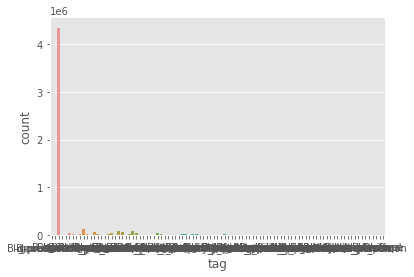

In [9]:
import seaborn as sns
import tkinter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x='tag', data=data)

In [10]:
words = list(set(data["word"].values))
words.append("ENDPAD")
num_words = len(words)

In [11]:
tags = list(set(data["tag"].values))
num_tags = len(tags)

In [12]:
num_words, num_tags

(452446, 95)

In [13]:
data["word"][0]

'NGC'

### 3: Retrieve Sentences and Corresponsing Tags

In [14]:
def SentenceGetter(data):
    word = data["word"]
    tag = data["tag"]
    sentences = []
    stc = []
    for w, t in zip(data["word"].values.tolist() , data["tag"].values.tolist()):
        if w != ' ':
            sentences.append((w , t)) 
        
        if w == '.':
            stc.append(sentences)
            sentences = []
    return stc

In [15]:
sentences = SentenceGetter(data)
sentences[0]

[('NGC', 'B-space'),
 ('5713', 'I-space'),
 ('Başak', 'O'),
 ('takımyıldızı', 'O'),
 ('bölgesinde', 'O'),
 ('bulunan', 'O'),
 ('tuhaf', 'O'),
 ('asimetrik', 'O'),
 ('gökada', 'O'),
 ('.', 'O')]

### 4: Define Mappings between Sentences and Tags

In [16]:
# enumerate() -> add a counter to an iterable and returns it
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [17]:
tag2idx

{'B-quantity': 0,
 'I-architect_person': 1,
 'B-organization': 2,
 'I-ship': 3,
 'B-government': 4,
 'B-ship': 5,
 'I-sport': 6,
 'B-subject': 7,
 'I-organization': 8,
 'B-genre': 9,
 'B-newspaper': 10,
 'I-military_person': 11,
 'B-measure': 12,
 'I-tech': 13,
 'B-chemical': 14,
 'I-chemical': 15,
 'I-country': 16,
 'B-train': 17,
 'B-medical': 18,
 'I-currency': 19,
 'B-organization_person': 20,
 'I-food': 21,
 'B-capital': 22,
 'O': 23,
 'B-clothes': 24,
 'B-structure': 25,
 'B-military_person': 26,
 'I-language': 27,
 'B-nation': 28,
 'B-sport_person': 29,
 'B-military': 30,
 'B-material': 31,
 'B-location': 32,
 'B-culture': 33,
 'I-science': 34,
 'I-anatomy': 35,
 'B-sport_name': 36,
 'I-location': 37,
 'I-subject': 38,
 'I-government_person': 39,
 'B-aircraft': 40,
 'I-sport_name': 41,
 'B-currency': 42,
 'B-sport': 43,
 'I-space_person': 44,
 'B-anatomy': 45,
 'B-album_person': 46,
 'I-organization_person': 47,
 'I-culture': 48,
 'I-measure': 49,
 'B-shape': 50,
 'B-language': 

### 5: Padding Input Sentences and Creating Train/Test Splits

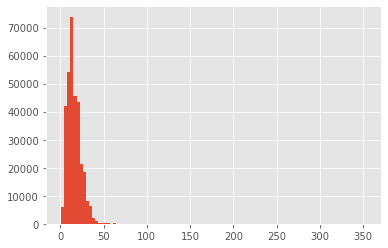

In [18]:
plt.hist([len(s) for s in sentences], bins=100)
plt.show()

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [20]:
X[0]

array([ 22217, 429922, 145048, 425674, 404635, 306038,  14378, 111441,
       128108,  77209, 452445, 452445, 452445, 452445, 452445, 452445,
       452445, 452445, 452445, 452445, 452445, 452445, 452445, 452445,
       452445, 452445, 452445, 452445, 452445, 452445, 452445, 452445,
       452445, 452445, 452445, 452445, 452445, 452445, 452445, 452445,
       452445, 452445, 452445, 452445, 452445, 452445, 452445, 452445,
       452445, 452445])

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### 6: Build and Compile a Bidirectional LSTM Model

In [22]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [23]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
# SpatialDropout1D -> rather than dropping dropping individual nodes, it drops the entire 1D feature map
model = SpatialDropout1D(0.1)(model)
# Rather than RNN, we are using LSTM to avoid Vanishing Gradient Problem
# using Bi-directional LSTM because, our model can learn from the entire input, rather than just the previous timestamps
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            22622300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 95)            19095     
Total params: 22,762,195
Trainable params: 22,762,195
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

### 7: Train the Model

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from livelossplot import PlotLossesKeras
import keras
from keras.models import load_model

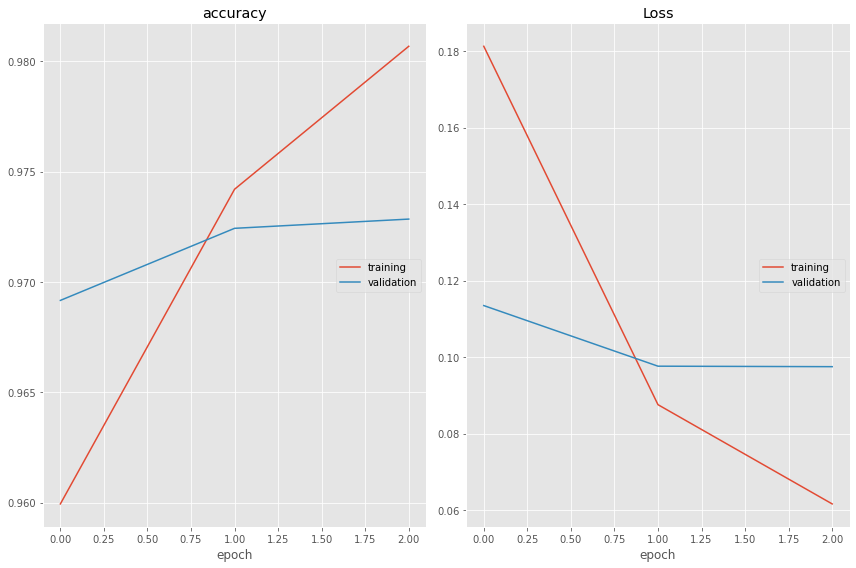

accuracy
	training         	 (min:    0.960, max:    0.981, cur:    0.981)
	validation       	 (min:    0.969, max:    0.973, cur:    0.973)
Loss
	training         	 (min:    0.062, max:    0.181, cur:    0.062)
	validation       	 (min:    0.097, max:    0.113, cur:    0.097)

Epoch 00003: val_loss improved from 0.09762 to 0.09749, saving model to model_ner_new.h5
7289/7289 [==============================] - 3184s 437ms/step - loss: 0.0616 - accuracy: 0.9807 - val_loss: 0.0975 - val_accuracy: 0.9728


In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)

filename = 'model_ner_new.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

callbacks = [PlotLossesKeras(), early_stopping, checkpoint]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=3,
    verbose=1,
    callbacks=callbacks
)

### 8: Evaluate Named Entity Recognition Model

In [27]:
model_ner_new = load_model("model_ner_new.h5")

In [28]:
model.evaluate(x_test, np.array(y_test))

1013/1013 [==============================] - 21s 20ms/step - loss: 0.0969 - accuracy: 0.97300s - loss: 0.0970 - accu


[0.09693113714456558, 0.9729602336883545]

In [29]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("word", "True", "Pred"))
print("-"*30)

idx = 0
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))
    idx += 1
    if idx == 15:
        break

word           True 	 Pred

------------------------------
Mor            B-location	O
Gabriel        I-location	O
Manastırı      I-location	O
,              O	O
dünyanın       O	O
ayakta         O	O
duran          O	O
en             O	O
eski           O	O
Süryani        O	O
Ortodoks       O	O
manastırıdır   B-location	O
.              O	O
Maniler        O	O
Maniler        O	O


In [30]:
def text_process(text):
    seq = []
    for w in text.split():
        try:
            seq.append(word2idx[w])
        except:
            seq.append(num_words-1)

    sz = len(seq)
    # print(seq)
    for _ in range(sz, 50):
        seq.append(num_words-1)
    seq = np.array(seq, dtype=int)
    return seq, sz

In [31]:
def get_ner(text):
    seq, sz = text_process(text)
    
    p = model_ner_new.predict(np.array([seq]))
    p = np.argmax(p, axis=-1)

    idx = 0
    for w, pred in zip(seq, p[0]):
        if tags[pred] != 'O':
            print("{:15}\t{}".format(words[w-1], tags[pred]))
        idx += 1
        if idx == sz:
            break

In [32]:
get_ner('Albert Einstein dünyanın gelmiş geçmiş en iyi fizikçilerindendir.')

Albert         	B-person
Einstein       	I-person


In [33]:
get_ner('Grammy ödülleri Fransa Devlet Başkanı tarafından verildi.')

Grammy         	B-production_art_music
ödülleri       	I-production_art_music
Fransa         	B-nation
Başkanı        	B-government


In [34]:
get_ner('Futbolda dünya kupası Brezilyanın oldu.')

Futbolda       	B-sport
Brezilyanın    	B-country


In [35]:
get_ner('Türkiye Büyük Millet Meclisi')

Türkiye        	B-nation
